# Annotated follow-along guide: EDA structuring with Python

This notebook contains the code used in the following instructional video: [EDA structuring with Python](https://www.coursera.org/learn/go-beyond-the-numbers-translate-data-into-insight/lecture/Pf6KW/eda-structuring-with-python)

## Introduction

Throughout this notebook, we will practice structuring data in Python. Before getting started, watch the associated instructional video and complete the in-video question. All of the code we will be implementing and related instructions are contained in this notebook.

## Overview

In this notebook, we will examine lightning strike data collected by the National Oceanic and Atmospheric Association (NOAA) for the year of 2018. To complete this notebook, we will:

* Find the locations with the greatest number of strikes within a single day
* Examine the locations that had the greatest number of days with at least one lightning strike 
* Determine whether certain days of the week had more lightning strikes than others  
* Add data from 2016 and 2017 and, for each month, calculate the percentage of total lightning strikes for that year that occurred in that month
* Plot this data on a bar graph

## Import packages and libraries

Before getting started, we will need to import all the required libraries and extensions. Throughout the course, we will be using pandas for operations, and matplotlib and seaborn for plotting.

In [2]:
# Import libraries and packages

# Import packages
from google.cloud import storage

import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib import cm
from datetime import datetime
import glob
import os
from io import StringIO
from io import BytesIO
import json
import pickle
import six
import charset_normalizer
from wordcloud import WordCloud 
from typing import List


sns.set()
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None

In [3]:
# RUN THIS CELL TO IMPORT YOUR DATA.
storage_client =  storage.Client.from_service_account_json('../heidless-jupyter-0-d2008100d98c.json')

BUCKET_NAME = 'heidless-jupyter-bucket-0'

bucket = storage_client.get_bucket(BUCKET_NAME)

AllCSV = []
my_prefix = 'eda-structuring-1/'
my_file = 'eda_structuring_with_python_dataset1.csv'
full_file = my_prefix + my_file
#print(f'full_file: {full_file}')

file_names = list(bucket.list_blobs(prefix=my_prefix))
for file in file_names:
    if(file.name != my_prefix):
        if file.name == full_file:
            AllCSV.append(file.name)
#            print(file.name)
AllCSV

['eda-structuring-1/eda_structuring_with_python_dataset1.csv']

In [4]:
# Display the first 10 rows of the data
all_dataframes = []

for csv in AllCSV:
    blob = bucket.get_blob(csv)
    if blob is not None and blob.exists(storage_client):
        bt = blob.download_as_string()
        s = str(bt, 'ISO-8859-1')
        s = StringIO(s)
        df = pd.read_csv(s, encoding='ISO-8859-1', low_memory=False)

        #df['country'] = csv[0:2] # adding column 'country' so that each dataset could be identified uniquely
        all_dataframes.append(df)
        print(csv)


eda-structuring-1/eda_structuring_with_python_dataset1.csv


### Organize the data

In [5]:
# Read in the 2016 data.
#df = pd.read_csv('eda_structuring_with_python_dataset1.csv') 
df.head()

date  number_of_strikes center_point_geom
0  2018-01-03                194     POINT(-75 27)
1  2018-01-03                 41   POINT(-78.4 29)
2  2018-01-03                 33   POINT(-73.9 27)
3  2018-01-03                 38   POINT(-73.8 27)
4  2018-01-03                 92     POINT(-79 28)

Just like the data you encountered previously, this dataset has three columns: `date`, `number_of_strikes`, and `center_point_geom`. Start by converting the `date` column to datetime. 

In [6]:
# Convert the `date` column to datetime.
df['date'] = pd.to_datetime(df['date']) 

Now, let's check the shape of the dataframe. 

In [7]:
df.shape

(3401012, 3)

Check for duplicates. If the shape of the data is different after running this code, you will know there were duplicate rows.

In [8]:
df.drop_duplicates().shape

(3401012, 3)

The shape of the dataset after dropping duplicates is the same, so you can assume there are no duplicates. Hence, there is at most one row per date, per area, and per number of strikes. 

### Locations with most strikes in a single day

To identify the locations with the most strikes in a single day, we will sort the `number_of_strikes` column in descending value, or by most to least strikes.

In [9]:
# Sort by number of strikes in descending order.
df.sort_values(by='number_of_strikes', ascending=False).head(10)

date  number_of_strikes  center_point_geom
302758 2018-08-20               2211  POINT(-92.5 35.5)
278383 2018-08-16               2142  POINT(-96.1 36.1)
280830 2018-08-17               2061  POINT(-90.2 36.1)
280453 2018-08-17               2031  POINT(-89.9 35.9)
278382 2018-08-16               1902  POINT(-96.2 36.1)
11517  2018-02-10               1899  POINT(-95.5 28.1)
277506 2018-08-16               1878  POINT(-89.7 31.5)
24906  2018-02-25               1833  POINT(-98.7 28.9)
284320 2018-08-17               1767    POINT(-90.1 36)
24825  2018-02-25               1741      POINT(-98 29)

### Locations with most days with at least one lightning strike


To find the number of days that a given geographic location had at least one lightning strike, we will use the `value_counts()` function on the `center_point_geom` column. The logic is that if each row represents a location-day, then counting the number of times each location occurs in the data will give you the number of days that location had lightning. 

In [10]:
# Identify the locations that appear most in the dataset.
df.center_point_geom.value_counts()

center_point_geom
POINT(-81.5 22.5)     108
POINT(-84.1 22.4)     108
POINT(-82.5 22.9)     107
POINT(-82.7 22.9)     107
POINT(-82.5 22.8)     106
POINT(-84.2 22.3)     106
POINT(-76 20.5)       105
POINT(-75.9 20.4)     105
POINT(-82.2 22.9)     104
POINT(-78 18.2)       104
POINT(-83.9 22.5)     103
POINT(-84 22.4)       102
POINT(-82 22.8)       102
POINT(-82 22.4)       102
POINT(-82.3 22.9)     102
POINT(-78 18.3)       102
POINT(-84.1 22.5)     101
POINT(-75.5 20.6)     101
POINT(-84.2 22.4)     101
POINT(-76 20.4)       101
POINT(-84 22.5)       101
POINT(-78.2 18.3)     101
POINT(-82 22.3)       101
POINT(-82.1 22.9)     100
POINT(-80.9 22.4)     100
POINT(-82.2 22.8)     100
POINT(-81.6 22.5)     100
POINT(-82.4 23)       100
POINT(-75.9 20.5)     100
POINT(-84.3 22.3)     100
POINT(-81.7 22.3)     100
POINT(-82.5 23)        99
POINT(-83 22.8)        99
POINT(-83.3 22.8)      99
POINT(-81.8 22.4)      99
POINT(-81.9 22.4)      99
POINT(-82.6 22.8)      99
POINT(-82.8 22.8)   

The locations with the most days with lightning strikes had at least one strike on 108 days—nearly one out of every three days of the year. These locations are all rather close to each other geographically. Notice also that the `value_counts()` function automatically sorts the results in descending order. 

Now we will examine whether there is an even distribution of values, or whether 108 strikes is an unusually high number of days with lightning strikes. We will use the `value_counts()` function again, but this time we will output the top 20 results. We will also rename the columns and apply a color gradient.

In [11]:
# Identify the top 20 locations with most days of lightning.
df.center_point_geom.value_counts()[:20].rename_axis('unique_values').reset_index(name='counts').style.background_gradient()

###  Lightning strikes by day of week

One useful grouping is categorizing lightning strikes by day of the week, which will tell us whether any particular day of the week had fewer or more lightning strikes than others. To calculate this, we will take advantage of the fact that the data in our `date` column is of the `datetime` class. Because these entries are datetime objects, we can extract date-related information from them and create new columns.

First, we will create a column called `week` using `dt.isocalendar()` on the `date` column. This function is designed to be used on a pandas series, and it will return a new dataframe with year, week, and day columns. The information is formatted numerically; for example, January 3, 1950, would be represented as:

| Year | Week | Day |
| ---- | :--: | :-: |
| 1950 | 1    | 3   |

Because we only want to extract the week number, we will add `.week` to the end. You can learn more about `dt.isocalendar()` in the [pandas.Series.dt.isocalendar documentation](https://pandas.pydata.org/pandas-docs/dev/reference/api/pandas.Series.dt.isocalendar.html).

We will also add a `weekday` column using `dt.day_name()`. This is another pandas function designed to be used on a pandas series. It extracts the text name of the day for any given datetime date. You can learn more about this function in the [pandas.Series.dt.day_name documentation](https://pandas.pydata.org/pandas-docs/dev/reference/api/pandas.Series.dt.day_name.html).


In [20]:
# Create two new columns.
df['week'] = df.date.dt.isocalendar().week
df['weekday'] = df.date.dt.day_name()
df.head()

date  number_of_strikes  center_point_geom  week  weekday
0 2016-01-04                 55  POINT(-83.2 21.1)     1   Monday
1 2016-01-04                 33  POINT(-83.1 21.1)     1   Monday
2 2016-01-05                 46  POINT(-77.5 22.1)     1  Tuesday
3 2016-01-05                 28  POINT(-76.8 22.3)     1  Tuesday
4 2016-01-05                 28    POINT(-77 22.1)     1  Tuesday

Now, we can calculate the mean number of lightning strikes for each weekday of the year. We will use the `groupby()` function to do this.

In [13]:
# Calculate the mean count of lightning strikes for each weekday.
df[['weekday','number_of_strikes']].groupby(['weekday']).mean()

number_of_strikes
weekday                     
Friday             13.349972
Monday             13.152804
Saturday           12.732694
Sunday             12.324717
Thursday           13.240594
Tuesday            13.813599
Wednesday          13.224568

It seems that Saturday and Sunday have fewer lightning strikes on average than the other five weekdays. We will plot the distributions of the strike counts for each day of the week. We want each distribution to be represented as a boxplot. 

We will begin by defining the order of the days, starting with Monday and ending with Sunday. This is how the days will be ordered in the plot we create.

In [14]:
# Define order of days for the plot.
weekday_order = ['Monday','Tuesday', 'Wednesday', 'Thursday','Friday','Saturday','Sunday']

Now, we will code the plot. Remember that `showfliers` is the parameter that controls whether or not outliers are displayed in the plot. If we input `True`, outliers are included; if we input `False`, outliers are left off of the box plot. Keep in mind, we aren’t *deleting* any outliers from the dataset when we create this chart—we are only excluding them from the visualization.

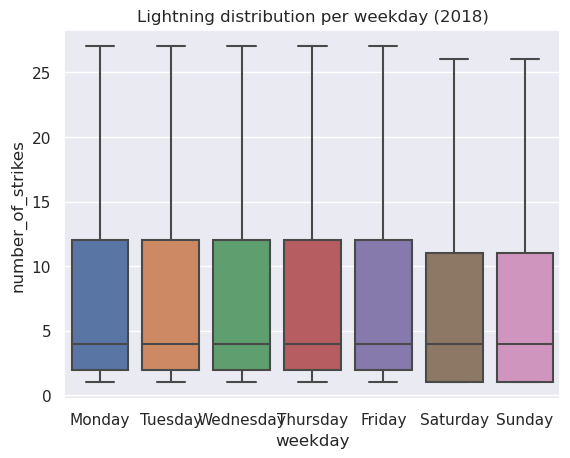

In [15]:
# Create boxplots of strike counts for each day of week.
g = sns.boxplot(data=df, 
            x='weekday',
            y='number_of_strikes', 
            order=weekday_order, 
            showfliers=False 
            );
g.set_title('Lightning distribution per weekday (2018)');

Notice that the median remains the same on all of the days of the week. As for Saturday and Sunday, however, the distributions are *both* lower than they are during the rest of the week. We also know that the mean numbers of strikes that occurred on Saturday and Sunday were lower than on the other weekdays. Why might this be? Perhaps the aerosol particles emitted by factories and vehicles increase the likelihood of lightning strikes. In the U.S., Saturday and Sunday are days that many people don't work, so there may be fewer factories operating and fewer cars on the road. This is only speculation, but it's one possible path for further exploration. 

### Monthly lightning strikes 2016–2018

Finally, we will examine monthly lightning strike data from 2016–2018. We will calculate the percentage of total lightning strikes for each year that occurred in a given month. We will then plot this data on a bar graph.

In [16]:
AllCSV = []
my_prefix = 'eda-structuring-1/'
my_file = 'eda_structuring_with_python_dataset2.csv'
full_file = my_prefix + my_file
#print(f'full_file: {full_file}')

file_names = list(bucket.list_blobs(prefix=my_prefix))
for file in file_names:
    if(file.name != my_prefix):
        if file.name == full_file:
            AllCSV.append(file.name)
#            print(file.name)
AllCSV

['eda-structuring-1/eda_structuring_with_python_dataset2.csv']

In [21]:
# Display the first 10 rows of the data
all_dataframes = []

for csv in AllCSV:
    blob = bucket.get_blob(csv)
    if blob is not None and blob.exists(storage_client):
        bt = blob.download_as_string()
        s = str(bt, 'ISO-8859-1')
        s = StringIO(s)
        df = pd.read_csv(s, encoding='ISO-8859-1', low_memory=False)

        #df['country'] = csv[0:2] # adding column 'country' so that each dataset could be identified uniquely
        all_dataframes.append(df)
        print(csv)
        
df_2 = all_dataframes[0]
df_2.head()

eda-structuring-1/eda_structuring_with_python_dataset2.csv


date  number_of_strikes  center_point_geom
0  2016-01-04                 55  POINT(-83.2 21.1)
1  2016-01-04                 33  POINT(-83.1 21.1)
2  2016-01-05                 46  POINT(-77.5 22.1)
3  2016-01-05                 28  POINT(-76.8 22.3)
4  2016-01-05                 28    POINT(-77 22.1)

##### Import 2016–2017 data
df_2 = pd.read_csv('eda_structuring_with_python_dataset2.csv')
df_2.head()

The data is in the same format as the 2018 data when we imported it previously. Now, we will convert the `date` column to datetime.

In [22]:
# Convert `date` column to datetime.
df_2['date'] = pd.to_datetime(df_2['date'])

Now we can combine the 2016–2017 dataframe with the 2018 dataframe. There are several functions that can do this. We will use `concat()`. Remember that the 2018 data has two added columns: `week` and `weekday`. To simplify the results of our combined dataframe, we will drop these added columns during the concatenation. Note that the following code doesn't permanently modify `df`. The columns drop only for this operation. You can learn more about the `concat()` function in the [pandas.concat documentation](https://pandas.pydata.org/docs/reference/api/pandas.concat.html).

In [23]:
# Create a new dataframe combining 2016–2017 data with 2018 data.
union_df = pd.concat([df.drop(['weekday','week'],axis=1), df_2], ignore_index=True)
union_df.head()

KeyError: "['weekday', 'week'] not found in axis"

To help us name the bars of the bar plot, we will create three new columns that isolate the year, month number, and month name. 

In [1]:
# Add 3 new columns.
union_df['year'] = union_df.date.dt.year
union_df['month'] = union_df.date.dt.month
union_df['month_txt'] = union_df.date.dt.month_name()
union_df.head()

NameError: name 'union_df' is not defined

Let's check the overall lightning strike count for each year.

In [40]:
# Calculate total number of strikes per year
union_df[['year','number_of_strikes']].groupby(['year']).sum()

number_of_strikes
year                   
2016           83164458
2017           70190390

Now we will calculate the percentage of total lightning strikes that occurred in a given month for each year and assign the results to a new dataframe called `lightning_by_month`. 

In [18]:
# Calculate total lightning strikes for each month of each year.
lightning_by_month = union_df.groupby(['month_txt','year']).agg(
    number_of_strikes = pd.NamedAgg(column='number_of_strikes',aggfunc=sum)
    ).reset_index()

lightning_by_month.head()

month_txt  year  number_of_strikes
0     April  2016            2636427
1     April  2017            3819075
2     April  2018            1524339
3    August  2016            7250442
4    August  2017            6021702

We can use the `agg()` function to calculate the same yearly totals we found before, with 2017 having fewer strikes than the other two years.

In [19]:
# Calculate total lightning strikes for each year.
lightning_by_year = union_df.groupby(['year']).agg(
  year_strikes = pd.NamedAgg(column='number_of_strikes',aggfunc=sum)
).reset_index()

lightning_by_year.head()

year  year_strikes
0  2016      41582229
1  2017      35095195
2  2018      44600989

In our bar plot, we need to use the monthly totals to calculate percentages. For each month, we will need the monthly total strike count and the total strike count for that year. Let's create another dataframe called `percentage_lightning` that adds a new column called `year_strikes` which represents the total number of strikes for each year. We can do this using the `merge()` function. We will merge the `lightning_by_month` dataframe with the `lightning_by_year` dataframe, specifying to merge on the `year` column. This means that wherever the `year` columns contain the same value in both dataframes, a row is created in our new dataframe with all the other columns from both dataframes being merged. To learn more about this function, refer to the [pandas.merge documentation](https://pandas.pydata.org/docs/reference/api/pandas.merge.html).


In [20]:
# Combine `lightning_by_month` and `lightning_by_year` dataframes into single dataframe.
percentage_lightning = lightning_by_month.merge(lightning_by_year,on='year')
percentage_lightning.head()

month_txt  year  number_of_strikes  year_strikes
0     April  2016            2636427      41582229
1    August  2016            7250442      41582229
2  December  2016             316450      41582229
3  February  2016             312676      41582229
4   January  2016             313595      41582229

Now we will create a new column in our new dataframe that represents the percentage of total lightning strikes that occurred during each month for each year. We will do this by dividing the `number_of_strikes` column by the `year_strikes` column and multiplying the result by 100.

In [21]:
# Create new `percentage_lightning_per_month` column.
percentage_lightning['percentage_lightning_per_month'] = (percentage_lightning.number_of_strikes/
                                                          percentage_lightning.year_strikes * 100.0)
percentage_lightning.head()

month_txt  year  number_of_strikes  year_strikes  \
0     April  2016            2636427      41582229   
1    August  2016            7250442      41582229   
2  December  2016             316450      41582229   
3  February  2016             312676      41582229   
4   January  2016             313595      41582229   

   percentage_lightning_per_month  
0                        6.340273  
1                       17.436396  
2                        0.761022  
3                        0.751946  
4                        0.754156

Now we can plot the percentages by month in a bar graph.

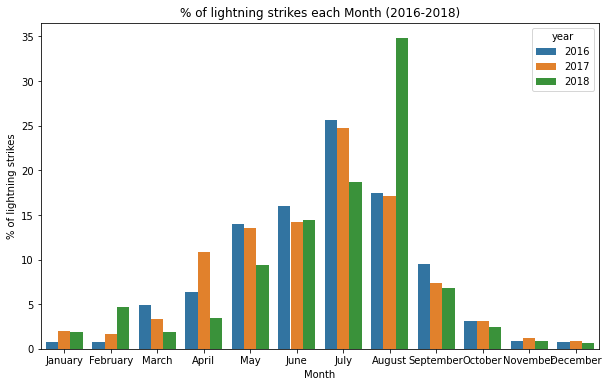

In [22]:
plt.figure(figsize=(10,6));

month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']

sns.barplot(
    data = percentage_lightning,
    x = 'month_txt',
    y = 'percentage_lightning_per_month',
    hue = 'year',
    order = month_order );
plt.xlabel("Month");
plt.ylabel("% of lightning strikes");
plt.title("% of lightning strikes each Month (2016-2018)");

For all three years, there is a clear pattern over the course of each year. One month stands out: August. More than one third of the lightning strikes in 2018 happened in August. 

## Conclusion

**Congratulations!** You've completed this lab. However, you may not notice a green check mark next to this item on Coursera's platform. Please continue your progress regardless of the check mark. Just click on the "save" icon at the top of this notebook to ensure your work has been logged.

You now understand how to structure data in Python and should be able to start applying this skill to your own datasets.